In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# download the data
df = pd.read_csv('BTC_2013_2023.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
#df['Price'] = df.Price.str.replace(',','')
df.set_index('Date',inplace=True)
y = df['Price']
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 120  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

In [ ]:
df_past = df[['Price']].reset_index()
df_past.rename(columns={'index': 'Date', 'Price': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

In [ ]:
past = df_past[['Date','Actual']]
past.rename(columns={'Actual':'Price'},inplace=True)
predict = df_future[['Date','Forecast']]
predict.rename(columns={'Forecast':'Price'},inplace=True)
results = past.append(predict).set_index('Date')
results = results.reset_index()
results['Price'] = results['Price'].astype('float')


<ipython-input-3-9f108af52561>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = past.append(predict).set_index('Date')


<Axes: xlabel='Date'>

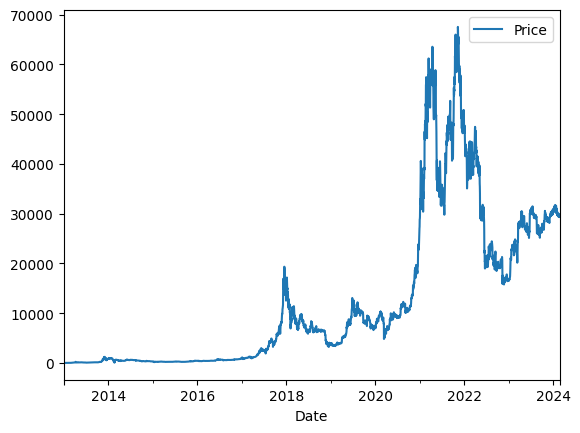

In [ ]:
results.plot(x = 'Date' , y = 'Price')

<Axes: xlabel='Date'>

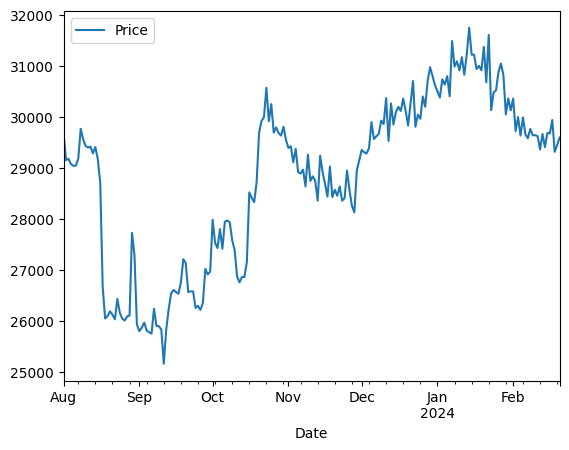

In [ ]:
results[results['Date'] >= '2023-08-01'].plot(x = 'Date' , y = 'Price')

In [ ]:
results[results['Date'] >= '2023-10-23']

,Date,Price
3947,2023-10-23,30568.796900
3948,2023-10-24,29914.050781
3949,2023-10-25,30249.990234
3950,2023-10-26,29691.992188
3951,2023-10-27,29793.841797
...,...,...
4063,2024-02-16,29673.250000
4064,2024-02-17,29938.509766
4065,2024-02-18,29314.830078
4066,2024-02-19,29450.277344
